In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import simps
from IPython.display import clear_output
import glob
import pybedtools as pbt

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

In [15]:
def extract_seq(bed_file, fasta_file, out_name):
    chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
    chrom_wise_intervals = {}
    for chrom in chroms:
        chrom_wise_intervals[chrom] = []
    with open (bed_file) as h:
        for l in h:
            c = l.split('\t')
            if c[0] in chroms:
                chrom_wise_intervals[c[0]].append((int(c[1]), int(c[2])))
    
    sequences = []
    fasta_base_dir ='/home/parashar/scratch/hg19_resource/chromosomes'
    nuc_map = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'N': 'N'}
    for chrom in chroms:
        print (chrom)
        chrom_seq = "".join([x.rstrip('\n') for x in
               open("%s/%s.fa" % (fasta_base_dir, chrom)).readlines()[1:]]).upper()
        for span in chrom_wise_intervals[chrom]:
            sequences.append(chrom_seq[span[0]:span[1]])
        clear_output()
    with open(out_name, 'w') as OUT:
        OUT.write("\n".join(sequences))

peaks_bed = pbt.BedTool('../data/chem_seq_g4/common_peaks.bed')
random_bed = peaks_bed.shuffle(g='/home/parashar/scratch/hg19_resource/hg19.genome', chrom=True).saveas(
    '../data/chem_seq_g4/random_peaks.bed')
extract_seq('../data/chem_seq_g4/common_peaks.bed',
            '/home/parashar/scratch/hg19_resource/genome.fa', '../data/chem_seq_g4/peaks.seq')
extract_seq('../data/chem_seq_g4/random_peaks.bed',
            '/home/parashar/scratch/hg19_resource/genome.fa', '../data/chem_seq_g4/random_peaks.seq')

In [16]:
! Rscript G4Hunter.r ../data/chem_seq_g4/peaks.seq ../data/chem_seq_g4/peaks_hunter_scores.txt
! Rscript G4Hunter.r ../data/chem_seq_g4/random_peaks.seq ../data/chem_seq_g4/random_peaks_hunter_scores.txt

[1] "../data/chem_seq_g4/peaks.seq"              
[2] "../data/chem_seq_g4/peaks_hunter_scores.txt"
Loading required package: S4Vectors
Loading required package: methods
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, ta

In [17]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

peaks_bed = pbt.BedTool('../data/chem_seq_g4/common_peaks.bed')
random_bed = pbt.BedTool('../data/chem_seq_g4/random_peaks.bed')

scores = []
random_scores = []
for chrom in chroms:
    exp_s = np.zeros(chrom_info[chrom])
    for strand in ['positive', 'negative']:
        scores_dir = '../data/quad_graph_single_base_scores/%s/%s/*_exp_score.npy' % (
            chrom, strand)
        for fn in tqdm(glob.glob(scores_dir), desc="%s %s" % (chrom, strand)):
            exp = np.load(fn)
            if exp.shape[0] > 1:
                e_indices = np.array(exp[:, 0], dtype=int)
                e_scores = np.array(exp[:, 1], dtype=float)
                exp_s[e_indices] += e_scores
    for i in peaks_bed:
        c = str(i).rstrip('\n').split('\t')
        if c[0] == chrom:
            scores.append(exp_s[int(c[1]):int(c[2])])
    for i in random_bed:
        c = str(i).rstrip('\n').split('\t')
        if c[0] == chrom:
            random_scores.append(exp_s[int(c[1]):int(c[2])])
    clear_output()
scores = np.array(scores)
random_scores = np.array(random_scores)
np.save('../data/chem_seq_g4/peaks_exp_scores', scores)
np.save('../data/chem_seq_g4/peaks_exp_random_scores', random_scores)

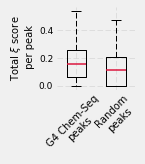

In [28]:
peak_exp = np.load('../data/chem_seq_g4/peaks_exp_scores.npy')
random_exp = np.load('../data/chem_seq_g4/peaks_exp_random_scores.npy')

fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([[max(x) for x in peak_exp], [max(x) for x in random_exp]], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
#ax.set_ylim((-0.05, 0.7))
ax.set_ylabel(r'Total $\xi$ score'+'\n per peak', fontsize=10)
clean_axis(ax)
ax.set_xticklabels(['G4 Chem-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)

plt.tight_layout()
plt.savefig('../images/g4_chem_seq_exp_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chem_seq_exp_scores.svg', transparent=True, edgecolor='none')
plt.show()
#mannwhitneyu([sum(x) for x in peak_exp], [sum(x) for x in random_exp])

In [24]:
len([max(x) for x in peak_exp if max(x) > 0.15])

254

(120,)
(0,)


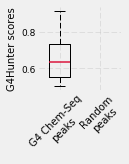

In [27]:
def load_hunter(fn):
    s = []
    with open(fn) as h:
        next(h)
        for l in h:
            c = l.rstrip('\n').split('\t')
            s.append(float(c[1]))
    s = np.array(s)
    s = s[s>0.5]
    print (s.shape)
    return s

peak_hunter_scores = load_hunter('../data/chem_seq_g4/peaks_hunter_scores.txt')
random_peaks_hunter_scores = load_hunter('../data/chem_seq_g4/random_peaks_hunter_scores.txt')

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([peak_hunter_scores, random_peaks_hunter_scores], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)

ax.set_ylabel('G4Hunter scores', fontsize=10)
clean_axis(ax)
ax.set_xticklabels(['G4 Chem-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=10)

plt.tight_layout()
plt.savefig('../images/g4_chem_seq_hunter_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/g4_chem_seq_hunter_scores.svg', transparent=True, edgecolor='none')
plt.show()